# Estimaciones Covid19 en Chile

In [1]:
import pandas as pd 
import requests
import io

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid') 
import numpy as np
import seaborn as sns
sns.set()

from ipywidgets import interact, widgets

from numpy import exp
from scipy.optimize import curve_fit

import warnings; warnings.simplefilter('ignore')

from datetime import date
from datetime import datetime

In [2]:
#https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
#df = pd.read_csv('./covid19.csv')
url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"

In [3]:
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))
df.head(3)
print('termine.')

termine.


In [4]:
hoy = date.today()
dia_del_anio = datetime.now().timetuple().tm_yday
print("Hoy es:", hoy, '| Dia del año:',dia_del_anio)

Hoy es: 2020-04-21 | Dia del año: 112


In [5]:
# Filtro x Pais

In [6]:
pais = 'Chile'
#pais = 'Mexico'
df_cl = df[ (df['countriesAndTerritories'] == pais) ]

In [7]:
df_cl.tail(2)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
2379,05/03/2020,5,3,2020,2,0,Chile,CL,CHL,18729160.0,America
2380,04/03/2020,4,3,2020,1,0,Chile,CL,CHL,18729160.0,America


In [8]:
df_cl['dia'] = pd.to_datetime(df_cl['dateRep'], format='%d/%m/%Y', errors='ignore').dt.dayofyear
df_cl.head(3)
df_cl.sort_values(by='dia', ascending=True, inplace=True)

In [9]:
print('ultimo dia con data:', df_cl['dia'].max(), ' | muertes:', df_cl['deaths'].sum())

ultimo dia con data: 112  | muertes: 139


In [10]:
#df_cl = df_cl[(df_cl['dia'] < 300) & (df_cl['dia'] > 1) ]
df_cl.tail(3)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp,dia
2335,19/04/2020,19,4,2020,478,10,Chile,CL,CHL,18729160.0,America,110
2334,20/04/2020,20,4,2020,358,7,Chile,CL,CHL,18729160.0,America,111
2333,21/04/2020,21,4,2020,419,6,Chile,CL,CHL,18729160.0,America,112


In [11]:
df_cl[['dia','deaths']].describe()

,dia,deaths
count,48.000000,48.000000
mean,88.416667,2.895833
std,14.135866,3.556472
min,64.000000,0.000000
25%,76.750000,0.000000
50%,88.500000,1.000000
75%,100.250000,5.250000
max,112.000000,11.000000


### 13/04/2020 es el dia 104 del Año 2020

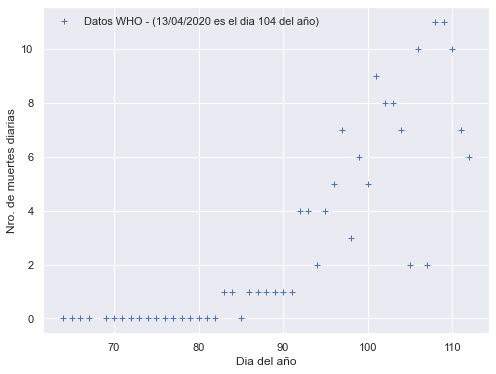

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(df_cl['dia'],df_cl['deaths'],'+', label='Datos WHO - (13/04/2020 es el dia 104 del año)');
plt.legend(loc='best')
plt.xlabel('Dia del año')
plt.ylabel('Nro. de muertes diarias')
plt.show()

In [13]:
x = df_cl['dia'].values
y = df_cl['deaths'].values

In [14]:
# Curva propuesta
def curva(x, amp, cen, q):
    #return amp * exp(-(x-cen)**2 )
    #return amp * ( 1 + q ) ** -x
    #return amp * (x - cen) **(q)
    return amp * exp((x-cen)**q)   

In [15]:
start = (1, 1, 1)
params, covar = curve_fit(curva, x, y, p0=start, maxfev=10000)
print(params) # ,'\n', covar)
print('last run: [1.96613471e-02 6.39999900e+01 4.75405703e-01]')

[2.52251606e-02 6.39999962e+01 4.62047405e-01]
last run: [1.96613471e-02 6.39999900e+01 4.75405703e-01]


In [16]:
solo_curva = False
if solo_curva:
    plt.plot(df_cl['dia'], curva(df_cl['dia'], params[0], params[1], params[2]),'+');

In [17]:
dia_pred = x.max()
dia_a_predecir = 0
dias_adelante  = 15
xx = []
yy = []
for i in range(dia_pred, dia_pred + dias_adelante):
    dia_a_predecir = i
    pred = ( curva(dia_a_predecir, params[0], params[1], params[2]) )
    #print(dia_a_predecir, pred)
    xx.append(i)
    yy.append(pred)

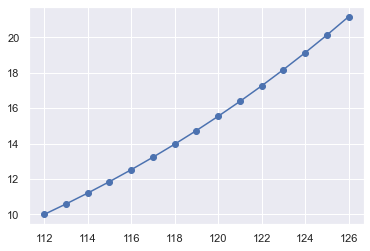

In [18]:
plt.plot(xx, yy, label='Curva supuesta', marker='o');

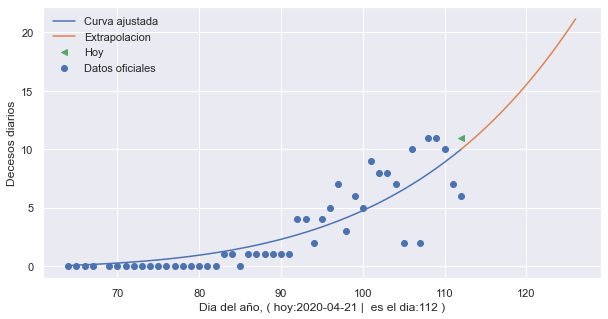

In [23]:
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='Datos oficiales')
plt.plot(x, curva(x, params[0], params[1], params[2]), label='Curva ajustada')
plt.plot(xx, yy, label='Extrapolacion')
plt.plot(dia_del_anio ,df_cl['deaths'].max(), '<',label='Hoy')
plt.legend(loc='best')
plt.xlabel('Dia del año, ( hoy:' + str(hoy) +' |  es el dia:' + str(dia_del_anio) +' )' )
plt.ylabel('Decesos diarios')
plt.show()

In [20]:
df_cl['deaths'].sum()

139

In [21]:
suma = df_cl['deaths'].sum()
i = 0
mm = []
ii = []
for d in xx:    
    try:
        pred = curva(d, params[0], params[1], params[2])
        #print(d, pred, suma)
    except:
        print(d, 'SD')
    suma = suma + pred
    mm.append(suma)
    ii.append(d)
    i = i + 1 

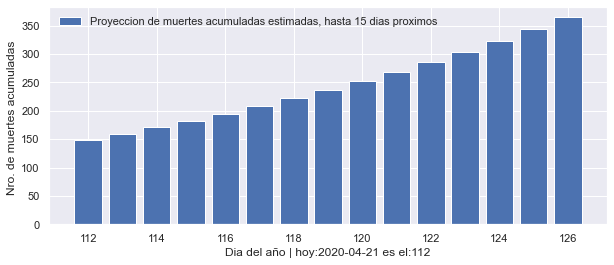

In [22]:
plt.figure(figsize=(10, 4))
plt.bar(ii, mm,label='Proyeccion de muertes acumuladas estimadas, hasta ' +str(dias_adelante)+ ' dias proximos');
plt.legend(loc='best')
plt.xlabel('Dia del año | hoy:' + str(hoy) +' es el:' + str(dia_del_anio))
plt.ylabel('Nro. de muertes acumuladas ')
plt.show()